In [77]:
# imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import sklearn
from sklearn.feature_selection import RFE, SequentialFeatureSelector, SelectFromModel
from sklearn.svm import SVC, LinearSVC
from sklearn.model_selection import StratifiedKFold, GridSearchCV, train_test_split, RandomizedSearchCV
from sklearn.feature_selection import RFE, RFECV, VarianceThreshold, SelectFromModel, SequentialFeatureSelector

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from boruta import BorutaPy
from lightgbm import LGBMClassifier
from sklearn.metrics import balanced_accuracy_score
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")
from scipy.stats import loguniform, uniform, randint

sns.set_style('whitegrid')

rs=123

In [2]:
# loading data

# artificial dataset
art_x_train = pd.read_csv('./data/artificial_train.data', sep=" ", header=None)
art_x_test = pd.read_csv('./data/artificial_valid.data', sep=" ", header=None)
art_y_train = np.array(pd.read_csv('./data/artificial_train.labels', header=None)[0].tolist())

# digits dataset
dig_x_train = pd.read_csv('./data/digits_train.data', sep=" ", header=None)
dig_x_test = pd.read_csv('./data/digits_valid.data', sep=" ", header=None)
dig_y_train = np.array(pd.read_csv('./data/digits_train.labels', header=None)[0].tolist())

In [3]:
# dropping unnecessary NaN columns
art_x_train.drop(columns=art_x_train.columns[-1], axis=1, inplace=True)
art_x_test.drop(columns=art_x_test.columns[-1], axis=1, inplace=True)
dig_x_train.drop(columns=dig_x_train.columns[-1], axis=1, inplace=True)
dig_x_test.drop(columns=dig_x_test.columns[-1], axis=1, inplace=True)

In [4]:
# artificial dataset
art_x_train.head()

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,485,477,537,479,452,471,491,476,475,473,...,477,481,477,485,511,485,481,479,475,496
1,483,458,460,487,587,475,526,479,485,469,...,463,478,487,338,513,486,483,492,510,517
2,487,542,499,468,448,471,442,478,480,477,...,487,481,492,650,506,501,480,489,499,498
3,480,491,510,485,495,472,417,474,502,476,...,491,480,474,572,454,469,475,482,494,461
4,484,502,528,489,466,481,402,478,487,468,...,488,479,452,435,486,508,481,504,495,511


In [5]:
# data size
print('Train: ' , art_x_train.shape)
print('Test: ', art_x_test.shape)

Train:  (2000, 500)
Test:  (600, 500)


-1    1000
 1    1000
dtype: int64


<AxesSubplot:ylabel='count'>

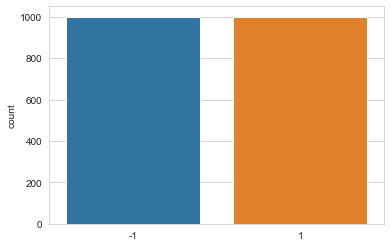

In [6]:
# target distribution
print(pd.Series(art_y_train).value_counts())
sns.countplot(art_y_train)

In [7]:
# digits dataset
dig_x_train.head()

,0,1,2,3,4,5,6,7,8,9,...,4990,4991,4992,4993,4994,4995,4996,4997,4998,4999
0,550,0,495,0,0,0,0,976,0,0,...,0,0,0,991,991,0,0,0,0,983
1,0,0,0,0,0,0,0,976,0,0,...,0,475,0,991,0,0,991,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,742,0,0,0,0,684,0,956,...,0,0,0,0,0,0,674,0,0,838
4,0,0,0,0,0,0,0,608,0,979,...,991,0,0,828,0,0,0,0,0,0


In [8]:
# data size
print('Train: ' , dig_x_train.shape)
print('Test: ', dig_x_test.shape)

Train:  (6000, 5000)
Test:  (1000, 5000)


 1    3000
-1    3000
dtype: int64


<AxesSubplot:ylabel='count'>

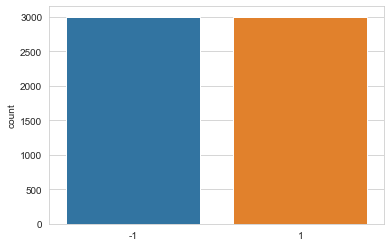

In [9]:
# target distribution
print(pd.Series(dig_y_train).value_counts())
sns.countplot(dig_y_train)

In [10]:
# train-valid split (stratification not needed - target perfectly balanced)
art_x_train, art_x_valid, art_y_train, art_y_valid = train_test_split(art_x_train, art_y_train, test_size=0.33, random_state=42)
dig_x_train, dig_x_valid, dig_y_train, dig_y_valid = train_test_split(dig_x_train, dig_y_train, test_size=0.33, random_state=42)

In [11]:
# crossvalidation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=1) 

In [21]:
# scaling - można spróbować innej metody i porównać
std = StandardScaler()
art_x_train_scaled = std.fit_transform(art_x_train)
art_x_valid_scaled = std.transform(art_x_valid)

std = StandardScaler()
dig_x_train_scaled = std.fit_transform(dig_x_train)
dig_x_valid_scaled = std.transform(dig_x_valid)

### Boruta

In [12]:
# artificial

In [28]:
rf = RandomForestClassifier(class_weight='balanced', max_depth=5) # z dokumentacji, można się pobawić moze coś zmieni
rf.fit(art_x_train_scaled, art_y_train)

RandomForestClassifier(class_weight='balanced', max_depth=5)

In [29]:
# define Boruta feature selection method
feat_selector = BorutaPy(rf, n_estimators='auto', verbose=2, random_state=1)
# patrząc na output - zmniejszenie max_iter (default 100) moze powodować wybranie mniejszej ilości zmiennych
# można też podać konkretna liczbe zmiennych która chcemy

# # find all relevant features
feat_selector.fit(np.array(art_x_train_scaled), art_y_train)

# # check selected features
# feat_selector.support_

# # check ranking of features
# feat_selector.ranking_

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	500
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	500
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	500
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	500
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	500
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	500
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	500
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	0
Tentative: 	24
Rejected: 	476
Iteration: 	9 / 100
Confirmed: 	13
Tentative: 	11
Rejected: 	476
Iteration: 	10 / 100
Confirmed: 	13
Tentative: 	11
Rejected: 	476
Iteration: 	11 / 100
Confirmed: 	13
Tentative: 	11
Rejected: 	476
Iteration: 	12 / 100
Confirmed: 	14
Tentative: 	10
Rejected: 	476
Iteration: 	13 / 100
Confirmed: 	14
Tentative: 	9
Rejected: 	477
Iteration: 	14 / 100
Confirmed: 	14
Tentative: 	9
Rejected: 	477
Iteration: 	15 / 100
Confirmed: 	14
Tentative: 	9
Rejected: 	477
Iteration: 	16 / 100
Confirmed: 	17
T

BorutaPy(estimator=RandomForestClassifier(class_weight='balanced', max_depth=5,
                                          n_estimators=135,
                                          random_state=RandomState(MT19937) at 0x15450AD6440),
         n_estimators='auto',
         random_state=RandomState(MT19937) at 0x15450AD6440, verbose=2)

In [30]:
art_x_train_boruta = feat_selector.transform(np.array(art_x_train_scaled))
art_x_valid_boruta = feat_selector.transform(np.array(art_x_valid_scaled))

In [31]:
rf = RandomForestClassifier() # moze próbowac grida zeby polepszyć
rf.fit(art_x_train_boruta, art_y_train)

RandomForestClassifier()

In [32]:
balanced_accuracy_score(art_y_valid, rf.predict(art_x_valid_boruta))

0.8803261827799

In [33]:
# digital - w pizde długo sie liczy xD na moim lapku niecałe 2h 3 iteracje, na serwerze nie miałam jak odpalic ani na słuzbowym
# moge walczyc po powrocie

In [71]:
rf = RandomForestClassifier(class_weight='balanced', max_depth=5) # z dokumentacji, można się pobawić moze coś zmieni
rf.fit(dig_x_train_scaled, dig_y_train)

RandomForestClassifier(class_weight='balanced', max_depth=5)

In [72]:
# define Boruta feature selection method
feat_selector = BorutaPy(rf, n_estimators='auto', verbose=2, random_state=1)
# patrząc na output - zmniejszenie max_iter (default 100) moze powodować wybranie mniejszej ilości zmiennych
# można też podać konkretna liczbe zmiennych która chcemy

# # find all relevant features
feat_selector.fit(np.array(dig_x_train_scaled), dig_y_train)

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	5000
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	5000
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	5000
Rejected: 	0


KeyboardInterrupt: 

In [ ]:
dig_x_train_boruta = feat_selector.transform(np.array(dig_x_train_scaled))
dig_x_valid_boruta = feat_selector.transform(np.array(dig_x_valid_scaled))

In [ ]:
rf = RandomForestClassifier()
rf.fit(dig_x_train_boruta, dig_y_train)

In [ ]:
balanced_accuracy_score(dig_y_valid, rf.predict(dig_x_valid_boruta))

### L1

In [68]:
scores = []
n_of_features = []
cs = np.arange(0.01, 5.01, 0.01)
for c in tqdm(cs):
    selector = SelectFromModel(LinearSVC(C=c, penalty="l1", dual=False, random_state=rs).fit(art_x_train_scaled, art_y_train), prefit=True)
    art_x_train_l1 = selector.transform(art_x_train_scaled)
    art_x_valid_l1 = selector.transform(art_x_valid_scaled)
    estimator = RandomForestClassifier(random_state=rs) 
    estimator.fit(art_x_train_l1, art_y_train)
    y_pred = estimator.predict(art_x_valid_l1)
    n_of_features.append(art_x_train_l1.shape[1])
    scores.append(balanced_accuracy_score(art_y_valid, y_pred))

100%|█████████████████████████████████████████| 500/500 [25:15<00:00,  3.03s/it]


<AxesSubplot:>

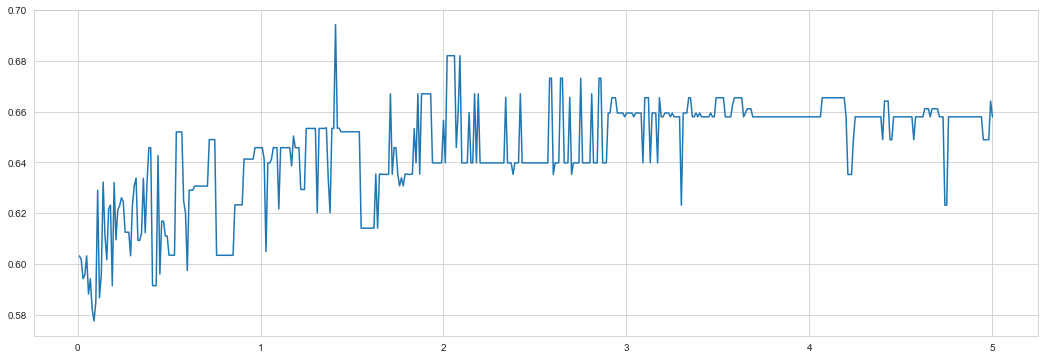

In [69]:
plt.figure(figsize=(18,6))
sns.lineplot(x=cs, y=scores) # no słabo to działa xD

In [70]:
# selecting only best scores for detailed analysis
ids_best = [i for i, elem in enumerate(scores) if elem > 0.68]
scores_best = [round(elem, 5) for i, elem in enumerate(scores) if i in ids_best]
n_of_features_best = [int(elem) for i, elem in enumerate(n_of_features) if i in ids_best]
cs_best = [elem for i, elem in enumerate(cs) if i in ids_best]
best_results = pd.DataFrame([cs_best, n_of_features_best, scores_best], index = ['C', 'No. of features', 'Balanced accuracy']).T
best_results = best_results.sort_values('No. of features').reset_index(drop=True)
best_results.style.background_gradient(cmap="Blues", axis=0) 

,C,No. of features,Balanced accuracy
0,1.410000,488.000000,0.694300
1,2.020000,490.000000,0.681990
2,2.030000,490.000000,0.681990
3,2.040000,490.000000,0.681990
4,2.050000,490.000000,0.681990
5,2.060000,490.000000,0.681990
6,2.090000,490.000000,0.681990


In [ ]:
# powtórzyć dla digits

In [75]:
scores = []
n_of_features = []
cs = np.arange(0.01, 5.01, 0.05)
for c in tqdm(cs):
    selector = SelectFromModel(LinearSVC(C=c, penalty="l1", dual=False, random_state=rs).fit(dig_x_train_scaled, dig_y_train), prefit=True)
    dig_x_train_l1 = selector.transform(dig_x_train_scaled)
    dig_x_valid_l1 = selector.transform(dig_x_valid_scaled)
    estimator = RandomForestClassifier(random_state=rs) 
    estimator.fit(dig_x_train_l1, dig_y_train)
    y_pred = estimator.predict(dig_x_valid_l1)
    n_of_features.append(dig_x_train_l1.shape[1])
    scores.append(balanced_accuracy_score(dig_y_valid, y_pred))

  6%|██▌                                        | 6/100 [03:40<57:37, 36.78s/it]


KeyboardInterrupt: 

In [ ]:
plt.figure(figsize=(18,6))
sns.lineplot(x=cs, y=scores) # no słabo to działa xD

### RFECV

In [ ]:
# artificial

In [78]:
rf = RandomForestClassifier(random_state=rs)
rfecv = RFECV(rf, step=1, cv=skf, scoring='balanced_accuracy')
rfecv = rfecv.fit(art_x_train_scaled, art_y_train)

In [79]:
rfecv.transform(art_x_train_scaled).shape[1] # number of selected features

20

In [81]:
y_pred = rfecv.predict(art_x_valid_scaled)
balanced_accuracy_score(art_y_valid, y_pred)

0.886405377607993

In [ ]:
# digits

In [ ]:
rf = RandomForestClassifier(random_state=rs)
rfecv = RFECV(rf, step=1, cv=skf, scoring='balanced_accuracy')
rfecv = rfecv.fit(dig_x_train_scaled, dig_y_train)

In [ ]:
rfecv.transform(dig_x_train_scaled).shape[1] # number of selected features

In [ ]:
y_pred = rfecv.predict(dig_x_valid_scaled)
balanced_accuracy_score(dig_y_valid, y_pred)

In [ ]:
### MCFS
# https://github.com/jundongl/scikit-feature/blob/master/skfeature/function/sparse_learning_based/MCFS.py

In [ ]:
##### poniżej - jakieś próbowane rzeczy, może się przyda docelowo
# grid search dla svmki 
# grid search dla lgbm

In [72]:
# SVM 
#model
model = Pipeline([('standardscaler', StandardScaler()), # to do wywalenia jeśli byśmy miały używać bo dane już zeskalowane
                  ('model', SVC())])

grid = [{
    'model__kernel': ['poly', 'sigmoid', 'rbf'],
    'model__C' : [1000, 500, 200, 100, 50, 10, 1.0, 0.1, 0.01],
    'model__gamma' : [1, 0.1, 0.01, 0.001, 0.0001]    
}]

gs = GridSearchCV(model,
                  param_grid=grid, 
                  scoring= 'balanced_accuracy', 
                  refit='balanced_accuracy', 
                  cv=skf, 
                  verbose=2)
gs.fit(art_x_train, art_y_train) # zmiana na _scaled

Fitting 5 folds for each of 135 candidates, totalling 675 fits
[CV] END ..model__C=1000, model__gamma=1, model__kernel=poly; total time=   1.0s
[CV] END ..model__C=1000, model__gamma=1, model__kernel=poly; total time=   0.5s
[CV] END ..model__C=1000, model__gamma=1, model__kernel=poly; total time=   0.9s
[CV] END ..model__C=1000, model__gamma=1, model__kernel=poly; total time=   0.6s
[CV] END ..model__C=1000, model__gamma=1, model__kernel=poly; total time=   0.4s
[CV] END model__C=1000, model__gamma=1, model__kernel=sigmoid; total time=   0.4s
[CV] END model__C=1000, model__gamma=1, model__kernel=sigmoid; total time=   0.3s
[CV] END model__C=1000, model__gamma=1, model__kernel=sigmoid; total time=   0.3s
[CV] END model__C=1000, model__gamma=1, model__kernel=sigmoid; total time=   0.5s
[CV] END model__C=1000, model__gamma=1, model__kernel=sigmoid; total time=   0.4s
[CV] END ...model__C=1000, model__gamma=1, model__kernel=rbf; total time=   0.7s
[CV] END ...model__C=1000, model__gamma=1

[CV] END model__C=500, model__gamma=0.1, model__kernel=sigmoid; total time=   0.4s
[CV] END ..model__C=500, model__gamma=0.1, model__kernel=rbf; total time=   0.6s
[CV] END ..model__C=500, model__gamma=0.1, model__kernel=rbf; total time=   0.6s
[CV] END ..model__C=500, model__gamma=0.1, model__kernel=rbf; total time=   0.7s
[CV] END ..model__C=500, model__gamma=0.1, model__kernel=rbf; total time=   0.6s
[CV] END ..model__C=500, model__gamma=0.1, model__kernel=rbf; total time=   0.6s
[CV] END model__C=500, model__gamma=0.01, model__kernel=poly; total time=   0.4s
[CV] END model__C=500, model__gamma=0.01, model__kernel=poly; total time=   0.4s
[CV] END model__C=500, model__gamma=0.01, model__kernel=poly; total time=   0.4s
[CV] END model__C=500, model__gamma=0.01, model__kernel=poly; total time=   0.4s
[CV] END model__C=500, model__gamma=0.01, model__kernel=poly; total time=   0.3s
[CV] END model__C=500, model__gamma=0.01, model__kernel=sigmoid; total time=   0.3s
[CV] END model__C=500, 

[CV] END model__C=200, model__gamma=0.001, model__kernel=poly; total time=   0.5s
[CV] END model__C=200, model__gamma=0.001, model__kernel=sigmoid; total time=   2.9s
[CV] END model__C=200, model__gamma=0.001, model__kernel=sigmoid; total time=   1.3s
[CV] END model__C=200, model__gamma=0.001, model__kernel=sigmoid; total time=   1.0s
[CV] END model__C=200, model__gamma=0.001, model__kernel=sigmoid; total time=   1.3s
[CV] END model__C=200, model__gamma=0.001, model__kernel=sigmoid; total time=   1.2s
[CV] END model__C=200, model__gamma=0.001, model__kernel=rbf; total time=   0.6s
[CV] END model__C=200, model__gamma=0.001, model__kernel=rbf; total time=   0.5s
[CV] END model__C=200, model__gamma=0.001, model__kernel=rbf; total time=   0.8s
[CV] END model__C=200, model__gamma=0.001, model__kernel=rbf; total time=   0.8s
[CV] END model__C=200, model__gamma=0.001, model__kernel=rbf; total time=   0.6s
[CV] END model__C=200, model__gamma=0.0001, model__kernel=poly; total time=   0.3s
[CV] 

[CV] END model__C=100, model__gamma=0.0001, model__kernel=rbf; total time=   0.5s
[CV] END ....model__C=50, model__gamma=1, model__kernel=poly; total time=   0.3s
[CV] END ....model__C=50, model__gamma=1, model__kernel=poly; total time=   0.3s
[CV] END ....model__C=50, model__gamma=1, model__kernel=poly; total time=   0.3s
[CV] END ....model__C=50, model__gamma=1, model__kernel=poly; total time=   0.3s
[CV] END ....model__C=50, model__gamma=1, model__kernel=poly; total time=   0.3s
[CV] END .model__C=50, model__gamma=1, model__kernel=sigmoid; total time=   0.3s
[CV] END .model__C=50, model__gamma=1, model__kernel=sigmoid; total time=   0.3s
[CV] END .model__C=50, model__gamma=1, model__kernel=sigmoid; total time=   0.3s
[CV] END .model__C=50, model__gamma=1, model__kernel=sigmoid; total time=   0.4s
[CV] END .model__C=50, model__gamma=1, model__kernel=sigmoid; total time=   0.4s
[CV] END .....model__C=50, model__gamma=1, model__kernel=rbf; total time=   0.6s
[CV] END .....model__C=50, 

[CV] END ...model__C=10, model__gamma=0.1, model__kernel=rbf; total time=   0.6s
[CV] END ...model__C=10, model__gamma=0.1, model__kernel=rbf; total time=   0.6s
[CV] END ...model__C=10, model__gamma=0.1, model__kernel=rbf; total time=   0.6s
[CV] END ...model__C=10, model__gamma=0.1, model__kernel=rbf; total time=   0.6s
[CV] END ...model__C=10, model__gamma=0.1, model__kernel=rbf; total time=   0.7s
[CV] END .model__C=10, model__gamma=0.01, model__kernel=poly; total time=   0.5s
[CV] END .model__C=10, model__gamma=0.01, model__kernel=poly; total time=   0.5s
[CV] END .model__C=10, model__gamma=0.01, model__kernel=poly; total time=   0.4s
[CV] END .model__C=10, model__gamma=0.01, model__kernel=poly; total time=   0.4s
[CV] END .model__C=10, model__gamma=0.01, model__kernel=poly; total time=   0.5s
[CV] END model__C=10, model__gamma=0.01, model__kernel=sigmoid; total time=   0.4s
[CV] END model__C=10, model__gamma=0.01, model__kernel=sigmoid; total time=   0.3s
[CV] END model__C=10, mo

[CV] END model__C=1.0, model__gamma=0.001, model__kernel=sigmoid; total time=   1.0s
[CV] END model__C=1.0, model__gamma=0.001, model__kernel=sigmoid; total time=   0.9s
[CV] END model__C=1.0, model__gamma=0.001, model__kernel=sigmoid; total time=   0.7s
[CV] END model__C=1.0, model__gamma=0.001, model__kernel=sigmoid; total time=   0.9s
[CV] END model__C=1.0, model__gamma=0.001, model__kernel=rbf; total time=   0.9s
[CV] END model__C=1.0, model__gamma=0.001, model__kernel=rbf; total time=   0.7s
[CV] END model__C=1.0, model__gamma=0.001, model__kernel=rbf; total time=   0.8s
[CV] END model__C=1.0, model__gamma=0.001, model__kernel=rbf; total time=   1.1s
[CV] END model__C=1.0, model__gamma=0.001, model__kernel=rbf; total time=   1.0s
[CV] END model__C=1.0, model__gamma=0.0001, model__kernel=poly; total time=   0.8s
[CV] END model__C=1.0, model__gamma=0.0001, model__kernel=poly; total time=   0.8s
[CV] END model__C=1.0, model__gamma=0.0001, model__kernel=poly; total time=   0.6s
[CV] E

[CV] END ..model__C=0.01, model__gamma=1, model__kernel=poly; total time=   1.1s
[CV] END ..model__C=0.01, model__gamma=1, model__kernel=poly; total time=   0.9s
[CV] END ..model__C=0.01, model__gamma=1, model__kernel=poly; total time=   0.7s
[CV] END ..model__C=0.01, model__gamma=1, model__kernel=poly; total time=   0.6s
[CV] END model__C=0.01, model__gamma=1, model__kernel=sigmoid; total time=   1.0s
[CV] END model__C=0.01, model__gamma=1, model__kernel=sigmoid; total time=   1.0s
[CV] END model__C=0.01, model__gamma=1, model__kernel=sigmoid; total time=   1.6s
[CV] END model__C=0.01, model__gamma=1, model__kernel=sigmoid; total time=   1.5s
[CV] END model__C=0.01, model__gamma=1, model__kernel=sigmoid; total time=   1.2s
[CV] END ...model__C=0.01, model__gamma=1, model__kernel=rbf; total time=   1.8s
[CV] END ...model__C=0.01, model__gamma=1, model__kernel=rbf; total time=   1.6s
[CV] END ...model__C=0.01, model__gamma=1, model__kernel=rbf; total time=   1.6s
[CV] END ...model__C=0.

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=1, shuffle=True),
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('model', SVC())]),
             param_grid=[{'model__C': [1000, 500, 200, 100, 50, 10, 1.0, 0.1,
                                       0.01],
                          'model__gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                          'model__kernel': ['poly', 'sigmoid', 'rbf']}],
             refit='balanced_accuracy', scoring='balanced_accuracy', verbose=2)

In [73]:
gs.best_params_

{'model__C': 1.0, 'model__gamma': 0.001, 'model__kernel': 'rbf'}

In [75]:
model = Pipeline([('standardscaler', StandardScaler()), # taki sam komentarz jak w grid searchu
                  ('model', SVC())])
model.set_params(**gs.best_params_)
model.fit(art_x_train, art_y_train) # _scaled
np.mean(art_y_valid == model.predict(art_x_valid)) # _scaled

0.5742424242424242

In [107]:
# LGBM
space = dict()
space['num_trees'] = randint(500,1500)
space['num_leaves'] = randint(5,40)
space['learning_rate'] = loguniform(0.01, 1)
space['boosting'] = ['gbdt', 'rf', 'dart', 'goss']
space['tree_learner'] = ['serial', 'feature', 'data', 'voting']

lgbm_clf = LGBMClassifier(objective='binary')

lgbm = RandomizedSearchCV(lgbm_clf,
                    space,
                    scoring='balanced_accuracy',
                    cv=skf,
                    n_iter=100,
                    refit=True,
                    random_state=1,
                    verbose=2)

lgbm.fit(art_x_train_boruta, art_y_train) 
lgbm_clf = LGBMClassifier(objective='binary')
lgbm_clf.set_params(**lgbm.best_params_)
lgbm_clf.fit(art_x_train_boruta, art_y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
[LightGBM] [Warning] boosting is set=rf, boosting_type=gbdt will be ignored. Current value: boosting=rf
[LightGBM] [Warning] num_iterations is set=1267, num_trees=1267 will be ignored. Current value: num_iterations=1267
[CV] END boosting=rf, learning_rate=0.9871192514273244, num_leaves=13, num_trees=1267, tree_learner=feature; total time=   0.0s
[CV] END boosting=rf, learning_rate=0.9871192514273244, num_leaves=13, num_trees=1267, tree_learner=feature; total time=   0.0s
[CV] END boosting=rf, learning_rate=0.9871192514273244, num_leaves=13, num_trees=1267, tree_learner=feature; total time=   0.0s
[CV] END boosting=rf, learning_rate=0.9871192514273244, num_leaves=13, num_trees=1267, tree_learner=feature; total time=   0.0s
[CV] END boosting=rf, learning_rate=0.9871192514273244, num_leaves=13, num_trees=1267, tree_learner=feature; total time=   0.0s
[CV] END boosting=goss, learning_rate=0.9955911573844395, num_leaves=5, num_t

[CV] END boosting=gbdt, learning_rate=0.06832971428089607, num_leaves=35, num_trees=1364, tree_learner=data; total time=   1.0s
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] num_iterations is set=1364, num_trees=1364 will be ignored. Current value: num_iterations=1364
[CV] END boosting=gbdt, learning_rate=0.06832971428089607, num_leaves=35, num_trees=1364, tree_learner=data; total time=   1.1s
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] num_iterations is set=1364, num_trees=1364 will be ignored. Current value: num_iterations=1364
[CV] END boosting=gbdt, learning_rate=0.06832971428089607, num_leaves=35, num_trees=1364, tree_learner=data; total time=   1.1s
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] num_iterations is set=1364, num_trees=1

[CV] END boosting=gbdt, learning_rate=0.039535805317396706, num_leaves=39, num_trees=971, tree_learner=voting; total time=   1.7s
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] num_iterations is set=971, num_trees=971 will be ignored. Current value: num_iterations=971
[CV] END boosting=gbdt, learning_rate=0.039535805317396706, num_leaves=39, num_trees=971, tree_learner=voting; total time=   1.7s
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] num_iterations is set=971, num_trees=971 will be ignored. Current value: num_iterations=971
[CV] END boosting=gbdt, learning_rate=0.039535805317396706, num_leaves=39, num_trees=971, tree_learner=voting; total time=   1.6s
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] num_iterations is set=971, num_trees=97

[CV] END boosting=goss, learning_rate=0.14749532034944685, num_leaves=28, num_trees=1293, tree_learner=voting; total time=   1.3s
[LightGBM] [Warning] boosting is set=goss, boosting_type=gbdt will be ignored. Current value: boosting=goss
[LightGBM] [Warning] num_iterations is set=1228, num_trees=1228 will be ignored. Current value: num_iterations=1228
[CV] END boosting=goss, learning_rate=0.8185991952096643, num_leaves=37, num_trees=1228, tree_learner=voting; total time=   0.6s
[LightGBM] [Warning] boosting is set=goss, boosting_type=gbdt will be ignored. Current value: boosting=goss
[LightGBM] [Warning] num_iterations is set=1228, num_trees=1228 will be ignored. Current value: num_iterations=1228
[CV] END boosting=goss, learning_rate=0.8185991952096643, num_leaves=37, num_trees=1228, tree_learner=voting; total time=   0.3s
[LightGBM] [Warning] boosting is set=goss, boosting_type=gbdt will be ignored. Current value: boosting=goss
[LightGBM] [Warning] num_iterations is set=1228, num_tre

[CV] END boosting=goss, learning_rate=0.1206636280191546, num_leaves=16, num_trees=832, tree_learner=voting; total time=   0.7s
[LightGBM] [Warning] boosting is set=goss, boosting_type=gbdt will be ignored. Current value: boosting=goss
[LightGBM] [Warning] num_iterations is set=832, num_trees=832 will be ignored. Current value: num_iterations=832
[CV] END boosting=goss, learning_rate=0.1206636280191546, num_leaves=16, num_trees=832, tree_learner=voting; total time=   0.7s
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] num_iterations is set=1313, num_trees=1313 will be ignored. Current value: num_iterations=1313
[CV] END boosting=gbdt, learning_rate=0.05690739192818569, num_leaves=12, num_trees=1313, tree_learner=serial; total time=   1.2s
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] num_iterations is set=1313, num_trees=13

[CV] END boosting=dart, learning_rate=0.05135949263684473, num_leaves=23, num_trees=970, tree_learner=data; total time=   4.2s
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] num_iterations is set=970, num_trees=970 will be ignored. Current value: num_iterations=970
[CV] END boosting=dart, learning_rate=0.05135949263684473, num_leaves=23, num_trees=970, tree_learner=data; total time=   4.1s
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] num_iterations is set=970, num_trees=970 will be ignored. Current value: num_iterations=970
[CV] END boosting=dart, learning_rate=0.05135949263684473, num_leaves=23, num_trees=970, tree_learner=data; total time=   4.1s
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] num_iterations is set=970, num_trees=970 will be

[CV] END boosting=gbdt, learning_rate=0.02211469818856329, num_leaves=30, num_trees=997, tree_learner=data; total time=   1.8s
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] num_iterations is set=997, num_trees=997 will be ignored. Current value: num_iterations=997
[CV] END boosting=gbdt, learning_rate=0.02211469818856329, num_leaves=30, num_trees=997, tree_learner=data; total time=   1.8s
[LightGBM] [Warning] boosting is set=rf, boosting_type=gbdt will be ignored. Current value: boosting=rf
[LightGBM] [Warning] num_iterations is set=1217, num_trees=1217 will be ignored. Current value: num_iterations=1217
[CV] END boosting=rf, learning_rate=0.24753483395116352, num_leaves=11, num_trees=1217, tree_learner=serial; total time=   0.0s
[CV] END boosting=rf, learning_rate=0.24753483395116352, num_leaves=11, num_trees=1217, tree_learner=serial; total time=   0.0s
[CV] END boosting=rf, learning_rate=0.24753483395

[CV] END boosting=gbdt, learning_rate=0.07141996801463805, num_leaves=37, num_trees=753, tree_learner=serial; total time=   1.3s
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] num_iterations is set=753, num_trees=753 will be ignored. Current value: num_iterations=753
[CV] END boosting=gbdt, learning_rate=0.07141996801463805, num_leaves=37, num_trees=753, tree_learner=serial; total time=   1.3s
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] num_iterations is set=753, num_trees=753 will be ignored. Current value: num_iterations=753
[CV] END boosting=gbdt, learning_rate=0.07141996801463805, num_leaves=37, num_trees=753, tree_learner=serial; total time=   1.5s
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] num_iterations is set=753, num_trees=753 w

[CV] END boosting=dart, learning_rate=0.014058467687542332, num_leaves=24, num_trees=751, tree_learner=data; total time=   3.1s
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] num_iterations is set=751, num_trees=751 will be ignored. Current value: num_iterations=751
[CV] END boosting=dart, learning_rate=0.014058467687542332, num_leaves=24, num_trees=751, tree_learner=data; total time=   2.9s
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] num_iterations is set=751, num_trees=751 will be ignored. Current value: num_iterations=751
[CV] END boosting=dart, learning_rate=0.014058467687542332, num_leaves=24, num_trees=751, tree_learner=data; total time=   2.8s
[LightGBM] [Warning] boosting is set=goss, boosting_type=gbdt will be ignored. Current value: boosting=goss
[LightGBM] [Warning] num_iterations is set=600, num_trees=600 will

[CV] END boosting=dart, learning_rate=0.05758141662606777, num_leaves=9, num_trees=1332, tree_learner=serial; total time=   3.1s
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] num_iterations is set=1168, num_trees=1168 will be ignored. Current value: num_iterations=1168
[CV] END boosting=gbdt, learning_rate=0.21800466494865894, num_leaves=22, num_trees=1168, tree_learner=data; total time=   0.6s
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] num_iterations is set=1168, num_trees=1168 will be ignored. Current value: num_iterations=1168
[CV] END boosting=gbdt, learning_rate=0.21800466494865894, num_leaves=22, num_trees=1168, tree_learner=data; total time=   0.6s
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] num_iterations is set=1168, num_trees=

[CV] END boosting=dart, learning_rate=0.2952105858077268, num_leaves=28, num_trees=770, tree_learner=voting; total time=   2.9s
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] num_iterations is set=770, num_trees=770 will be ignored. Current value: num_iterations=770
[CV] END boosting=dart, learning_rate=0.2952105858077268, num_leaves=28, num_trees=770, tree_learner=voting; total time=   2.9s
[LightGBM] [Warning] boosting is set=rf, boosting_type=gbdt will be ignored. Current value: boosting=rf
[LightGBM] [Warning] num_iterations is set=940, num_trees=940 will be ignored. Current value: num_iterations=940
[CV] END boosting=rf, learning_rate=0.731045045961062, num_leaves=8, num_trees=940, tree_learner=serial; total time=   0.0s
[CV] END boosting=rf, learning_rate=0.731045045961062, num_leaves=8, num_trees=940, tree_learner=serial; total time=   0.0s
[CV] END boosting=rf, learning_rate=0.731045045961062, num

[CV] END boosting=goss, learning_rate=0.844354956070893, num_leaves=12, num_trees=1227, tree_learner=voting; total time=   0.4s
[LightGBM] [Warning] boosting is set=goss, boosting_type=gbdt will be ignored. Current value: boosting=goss
[LightGBM] [Warning] num_iterations is set=1227, num_trees=1227 will be ignored. Current value: num_iterations=1227
[CV] END boosting=goss, learning_rate=0.844354956070893, num_leaves=12, num_trees=1227, tree_learner=voting; total time=   0.4s
[LightGBM] [Warning] boosting is set=rf, boosting_type=gbdt will be ignored. Current value: boosting=rf
[LightGBM] [Warning] num_iterations is set=1124, num_trees=1124 will be ignored. Current value: num_iterations=1124
[CV] END boosting=rf, learning_rate=0.018627660587130616, num_leaves=32, num_trees=1124, tree_learner=feature; total time=   0.0s
[CV] END boosting=rf, learning_rate=0.018627660587130616, num_leaves=32, num_trees=1124, tree_learner=feature; total time=   0.0s
[CV] END boosting=rf, learning_rate=0.01

[CV] END boosting=dart, learning_rate=0.07368052267166847, num_leaves=36, num_trees=1065, tree_learner=feature; total time=   5.0s
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] num_iterations is set=1065, num_trees=1065 will be ignored. Current value: num_iterations=1065
[CV] END boosting=dart, learning_rate=0.07368052267166847, num_leaves=36, num_trees=1065, tree_learner=feature; total time=   5.0s
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] num_iterations is set=1065, num_trees=1065 will be ignored. Current value: num_iterations=1065
[CV] END boosting=dart, learning_rate=0.07368052267166847, num_leaves=36, num_trees=1065, tree_learner=feature; total time=   5.3s
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] num_iterations is set=1065, nu

[CV] END boosting=gbdt, learning_rate=0.014107426511480064, num_leaves=23, num_trees=725, tree_learner=data; total time=   0.8s
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] num_iterations is set=725, num_trees=725 will be ignored. Current value: num_iterations=725
[CV] END boosting=gbdt, learning_rate=0.014107426511480064, num_leaves=23, num_trees=725, tree_learner=data; total time=   0.7s
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] num_iterations is set=725, num_trees=725 will be ignored. Current value: num_iterations=725
[CV] END boosting=gbdt, learning_rate=0.014107426511480064, num_leaves=23, num_trees=725, tree_learner=data; total time=   0.7s
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] num_iterations is set=725, num_trees=725 will

[CV] END boosting=dart, learning_rate=0.07252613627079757, num_leaves=33, num_trees=1049, tree_learner=feature; total time=   4.7s
[LightGBM] [Warning] boosting is set=rf, boosting_type=gbdt will be ignored. Current value: boosting=rf
[LightGBM] [Warning] num_iterations is set=1418, num_trees=1418 will be ignored. Current value: num_iterations=1418
[CV] END boosting=rf, learning_rate=0.024953977367349344, num_leaves=16, num_trees=1418, tree_learner=data; total time=   0.0s
[CV] END boosting=rf, learning_rate=0.024953977367349344, num_leaves=16, num_trees=1418, tree_learner=data; total time=   0.0s
[CV] END boosting=rf, learning_rate=0.024953977367349344, num_leaves=16, num_trees=1418, tree_learner=data; total time=   0.0s
[CV] END boosting=rf, learning_rate=0.024953977367349344, num_leaves=16, num_trees=1418, tree_learner=data; total time=   0.0s
[CV] END boosting=rf, learning_rate=0.024953977367349344, num_leaves=16, num_trees=1418, tree_learner=data; total time=   0.0s
[CV] END boost

[CV] END boosting=dart, learning_rate=0.420284166665532, num_leaves=21, num_trees=1243, tree_learner=feature; total time=   3.6s
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] num_iterations is set=1243, num_trees=1243 will be ignored. Current value: num_iterations=1243
[CV] END boosting=dart, learning_rate=0.420284166665532, num_leaves=21, num_trees=1243, tree_learner=feature; total time=   3.6s
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] num_iterations is set=1243, num_trees=1243 will be ignored. Current value: num_iterations=1243
[CV] END boosting=dart, learning_rate=0.420284166665532, num_leaves=21, num_trees=1243, tree_learner=feature; total time=   3.6s
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] num_iterations is set=1243, num_tree

[CV] END boosting=gbdt, learning_rate=0.02737573585687714, num_leaves=22, num_trees=1406, tree_learner=serial; total time=   1.1s
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] num_iterations is set=1406, num_trees=1406 will be ignored. Current value: num_iterations=1406
[CV] END boosting=gbdt, learning_rate=0.02737573585687714, num_leaves=22, num_trees=1406, tree_learner=serial; total time=   1.2s
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] num_iterations is set=1406, num_trees=1406 will be ignored. Current value: num_iterations=1406
[CV] END boosting=gbdt, learning_rate=0.02737573585687714, num_leaves=22, num_trees=1406, tree_learner=serial; total time=   1.1s
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] num_iterations is set=1406, num_t

[CV] END boosting=dart, learning_rate=0.01945768105370229, num_leaves=21, num_trees=1363, tree_learner=serial; total time=   4.1s
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] num_iterations is set=1363, num_trees=1363 will be ignored. Current value: num_iterations=1363
[CV] END boosting=dart, learning_rate=0.01945768105370229, num_leaves=21, num_trees=1363, tree_learner=serial; total time=   4.1s
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] num_iterations is set=1363, num_trees=1363 will be ignored. Current value: num_iterations=1363
[CV] END boosting=dart, learning_rate=0.01945768105370229, num_leaves=21, num_trees=1363, tree_learner=serial; total time=   4.2s
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] num_iterations is set=1363, num_t

0.8454545454545455

In [111]:
balanced_accuracy_score(art_y_valid, lgbm_clf.predict(art_x_valid_boruta))

0.8453937702027623

In [47]:
# przykład pipeline'a od razu z selekcja
clf = Pipeline([
  ('feature_selection', SelectFromModel(LogisticRegression())),
  ('classification', RandomForestClassifier())
])
clf.fit(art_x_train, art_y_train)